In [3]:
#to suppress all warnings and make more readable the notebook
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# This is TH+500

In [4]:
import sys
sys.path.insert(0, "/media/giuseppec/25F62A4E5FEED162/work/temporalis_update/brightway2-temporalis_last")
# sys.path.insert(0, "/media/giuseppec/25F62A4E5FEED162/work/temporalis_update/brightway2-temporalis_chris")

In [5]:
import warnings
warnings.filterwarnings('ignore')

from brightway2 import *
from bw2temporalis import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from bw2temporalis.dyn_methods.constants import co2_rf_td
import palettable


%matplotlib inline
# list(projects)

projects.set_current('temporalis_demo')

In [8]:
Database()

['Agribalyse 1.3 new biosphere',
 'agribalyse 1.3',
 'biosphere3',
 'ecoinvent 2.2',
 'ecoinvent 3.2 cutoff',
 'glu',
 'glu_orig',
 'tempo']

In [24]:
a=Database('glu')
b=a.parameters

import pprint
with open('parameters.py', 'wt') as out:
    pprint.pprint(list(b.items()), stream=out)



In [ ]:
pprint.p

# compare static and dynamic LCA using static LCIA 
`Here let's first check the difference in the cumulative results between the static and the dynamic LCA using the same LCIA method`

In [4]:
#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a'),
          100:('IPCC 2007', 'climate change', 'GWP 100a'),
          500:('IPCC 2007', 'climate change', 'GWP 500a')}
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 
    print('score static LCA with GWP{}: '.format(yr), round(l.score,2))

    dlca_st = DynamicLCA(FU, m,now=np.datetime64('2017-01-01'),cutoff=0.00000001,loop_cutoff=10)
    timel_st=dlca_st.calculate()
    yr_st,res_st=timel_st.characterize_static(m,cumulative=True)
    print('results dynamic with LCA with GWP{}: '.format(yr),round(res_st[-1],2))
    print("difference in percentage between the two: ", round((res_st[-1]-l.score)/(res_st[-1])*100,2))
    print()

score static LCA with GWP100:  -288.9


results dynamic with LCA with GWP100:  -288.93
difference in percentage between the two:  0.01

score static LCA with GWP20:  -222.46


results dynamic with LCA with GWP20:  -222.49
difference in percentage between the two:  0.02

score static LCA with GWP500:  -314.23


results dynamic with LCA with GWP500:  -314.27
difference in percentage between the two:  0.01



# dynamic LCI with static LCIA

In [4]:
fu={('tempo', 'glulam_FU'): 1}
method=('IPCC 2007', 'climate change', 'GWP 500a')
dlca = DynamicLCA(fu, method,now=np.datetime64('2017-01-01'),cutoff=0.00000001,loop_cutoff=10,group=True)
timeline=dlca.calculate()
y_st,r_st=timeline.characterize_static(method,cumulative=True)

In [5]:
#change name cols for graph and associate colors
names_cols={
'sawing, softwood': 'Sawnwood production',
'market for sawlog and veneer log, softwood, measured as solid wood under bark':'Raw wood production',
'glulam_eol': 'Glulam use-EOL',# 
 'glulam_prod': 'Glulam production',} 

#create dict with cols:colors
columns = ['Glulam production',
 'Glulam use-EOL',
 'Raw wood production',
 'Sawnwood production',
 'Total',
 'Total no biogenic']
colors = {'Glulam production':'b',
 'Glulam use-EOL':'gold',
 'Raw wood production':'g',
 'Sawnwood production':'r',
 'Total':'k',
'Total no biogenic':'k'}

In [6]:
#create dict with results by process

st_CF={}
for x in timeline.processes():
    yr_pr_st,res_pr_st=timeline.timeline_for_activity(x).characterize_static(method,cumulative=False)
    st_CF[get_activity(x)['name']]=[yr_pr_st,res_pr_st]

In [7]:
#convert dict with results to dataframe
df_st_CF=pd.DataFrame({k:pd.Series(v[1], index=v[0]) for (k,v) in st_CF.items() if len(v[0])>0})
df_st_CF.index=df_st_CF.index.map(int)#to have int in x axis


# # when cumulative=False in characterize_static
df_st_CF=df_st_CF.cumsum().ffill() 
#fill gaps in years and take only 500 yrs
df_st_CF=df_st_CF.reindex(range(df_st_CF.index.min(),2017+501),method='ffill').loc[:2017+501].ffill()#correct
# df_st_CF=df_st_CF.reindex(range(df_st_CF.index.min(),df_st_CF.index.max()),method='ffill')[:501].ffill()

lenght=len(df_st_CF) #lenght of the TH




# create tot
tot_st=pd.Series(index=[int(x) for x in  y_st],data=r_st)

#fill gaps in years and take only 500 yrs
# tot_st=tot_st.reindex(range(tot_st.index.min(),tot_st.index.max()),method='ffill')[:501]
tot_st=tot_st.reindex(range(tot_st.index.min(),2017+501),method='ffill').loc[:2017+501] #correct



In [8]:
#rename columns
df_st_CF.rename(columns=names_cols,inplace=True)

#merge duplicate columns
df_st_CF=df_st_CF.T.groupby(df_st_CF.T.index).sum().T

#reorder cols for better graph
st_cols_order=[]
for index, row in df_st_CF.iterrows():
    for x,y in row.iteritems():
        if pd.notnull(y) and x not in st_cols_order:
            st_cols_order.append(x)

df_st_CF = df_st_CF[st_cols_order]


    

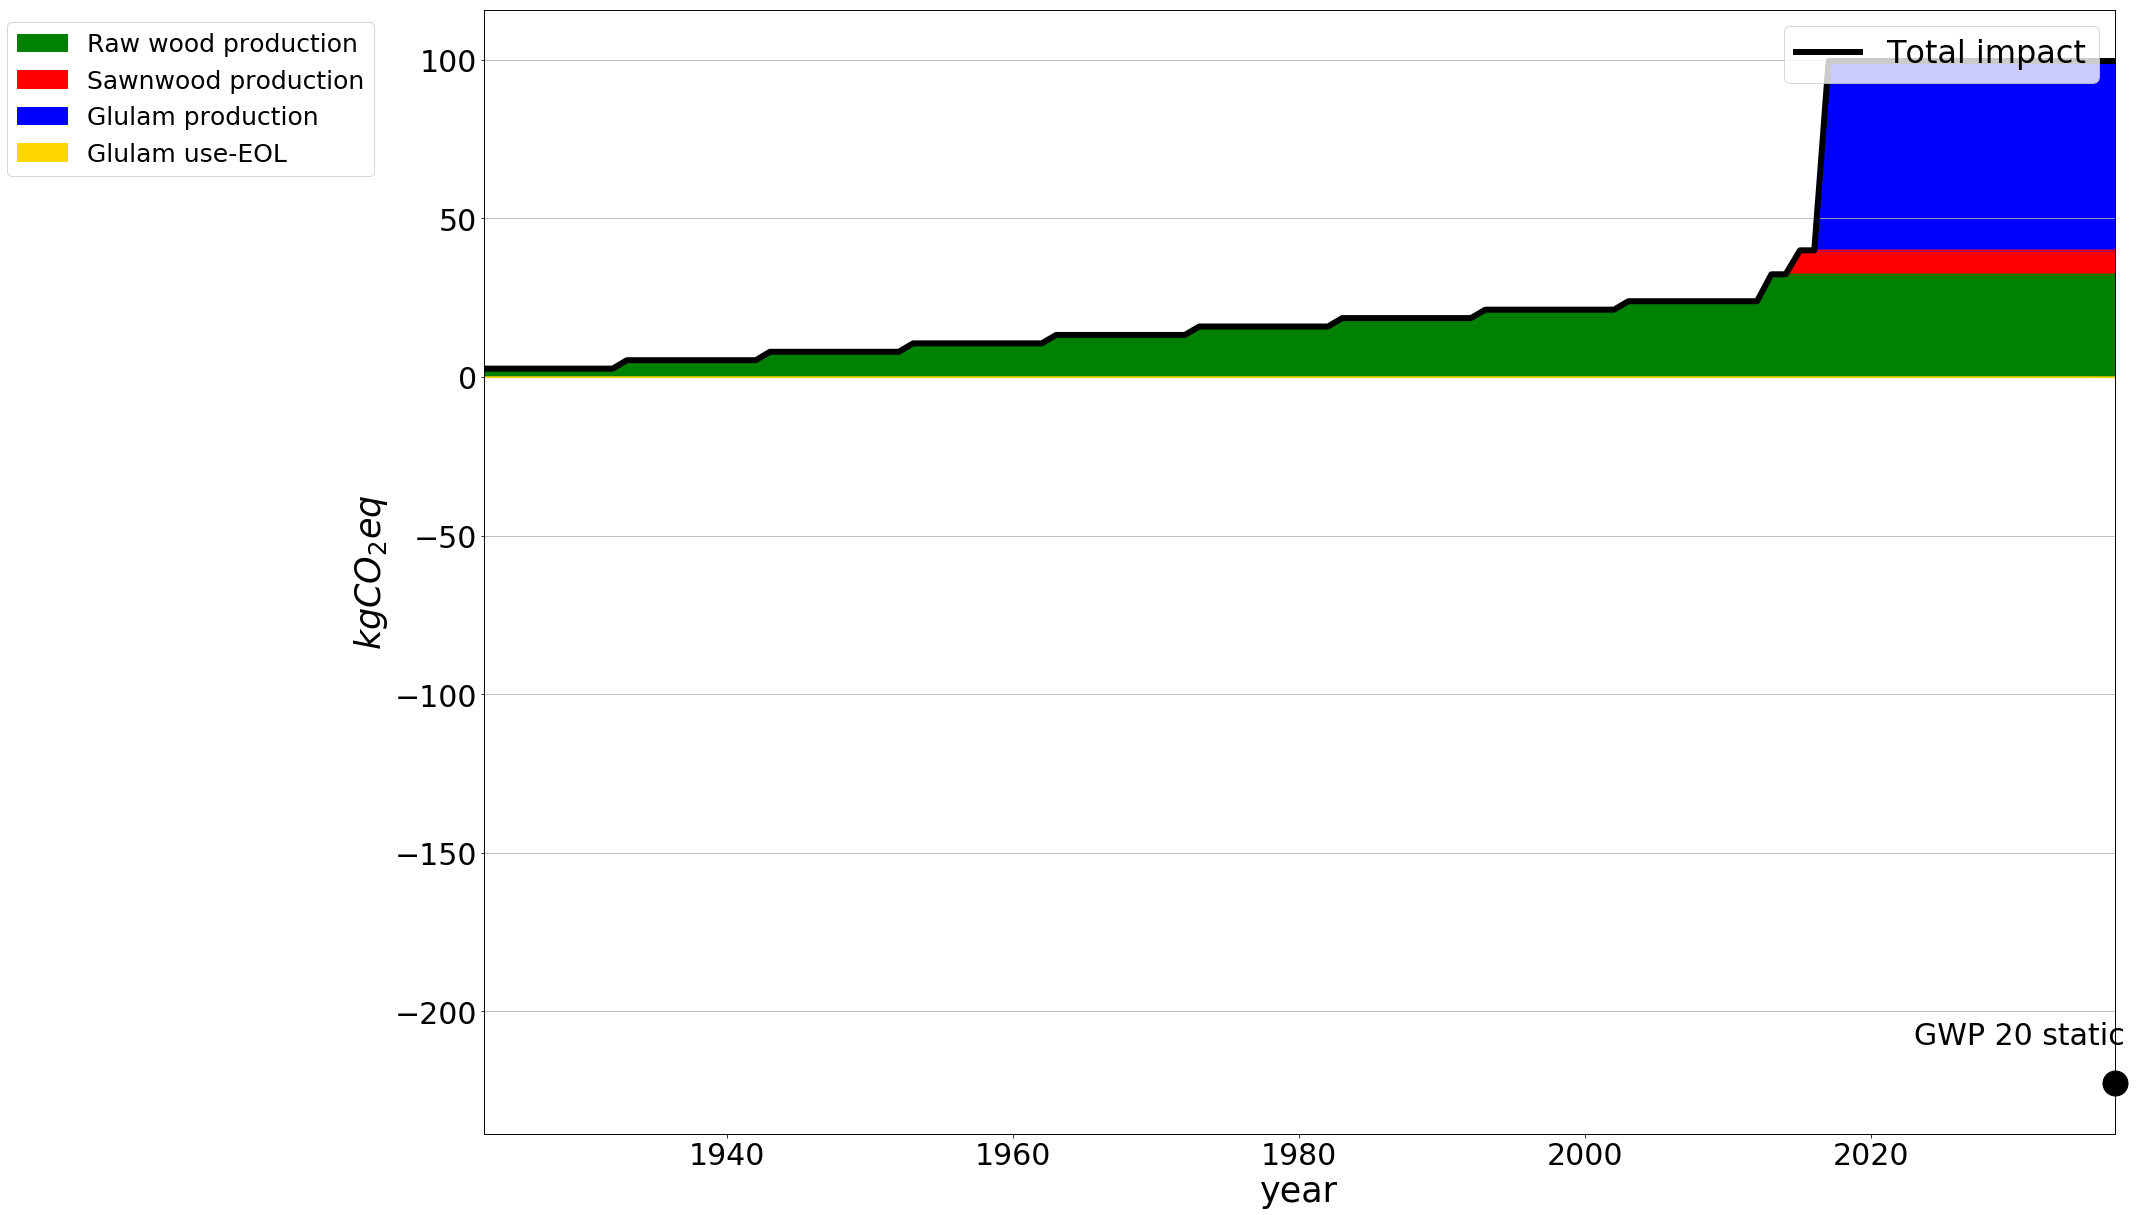

In [9]:
#plot 20 years
size_font=30


#to make everything bold see https://stackoverflow.com/a/43111170/4929813
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

fig, ax = plt.subplots(figsize=(11.69*2.5,8.27*2.5))#(33,18))
ax2 = ax.twiny()

#set colormap with palettable
# ax.set_color_cycle(palettable.tableau.Tableau_20.mpl_colors)

#plot
# df_st_CF.plot(kind='bar',stacked=True,legend=False,width=1.1,fontsize=size_font,ax=ax)#,colormap='Paired')
df_st_CF.loc[:2017+20].plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.iloc[:len(df_st_CF.loc[:2017+20])].plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax.grid(True,axis='y')

#adjsut legend
#correct
ax.legend(bbox_to_anchor=(-0.3, 1),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
ax2.legend(["Total impact"],fontsize=size_font+2,loc='upper right')


#x-ylabel
ax.set_ylabel('$kg CO_2eq$',fontsize=size_font+5)
ax.set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


#####ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a')
         }
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
line = ax2.lines[0] 
zero=line.get_xdata()[0]
xcoords = [zero+20]
    
#this starting from 2017
for xc in xcoords:
    ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
    ax2.annotate('GWP {} static'.format(xc-zero),
             xy=(xc+80, res[xc-zero]+12 ), 
             size=size_font
            )

#                  xy=(xc-60 if (xc-zero)==500 else xc+70, res[xc-zero]-20 ), 



# # need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
# # #for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.eps', format='eps',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.svg', format='svg',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.png', format='png',dpi=500,bbox_inches='tight')

plt.show()


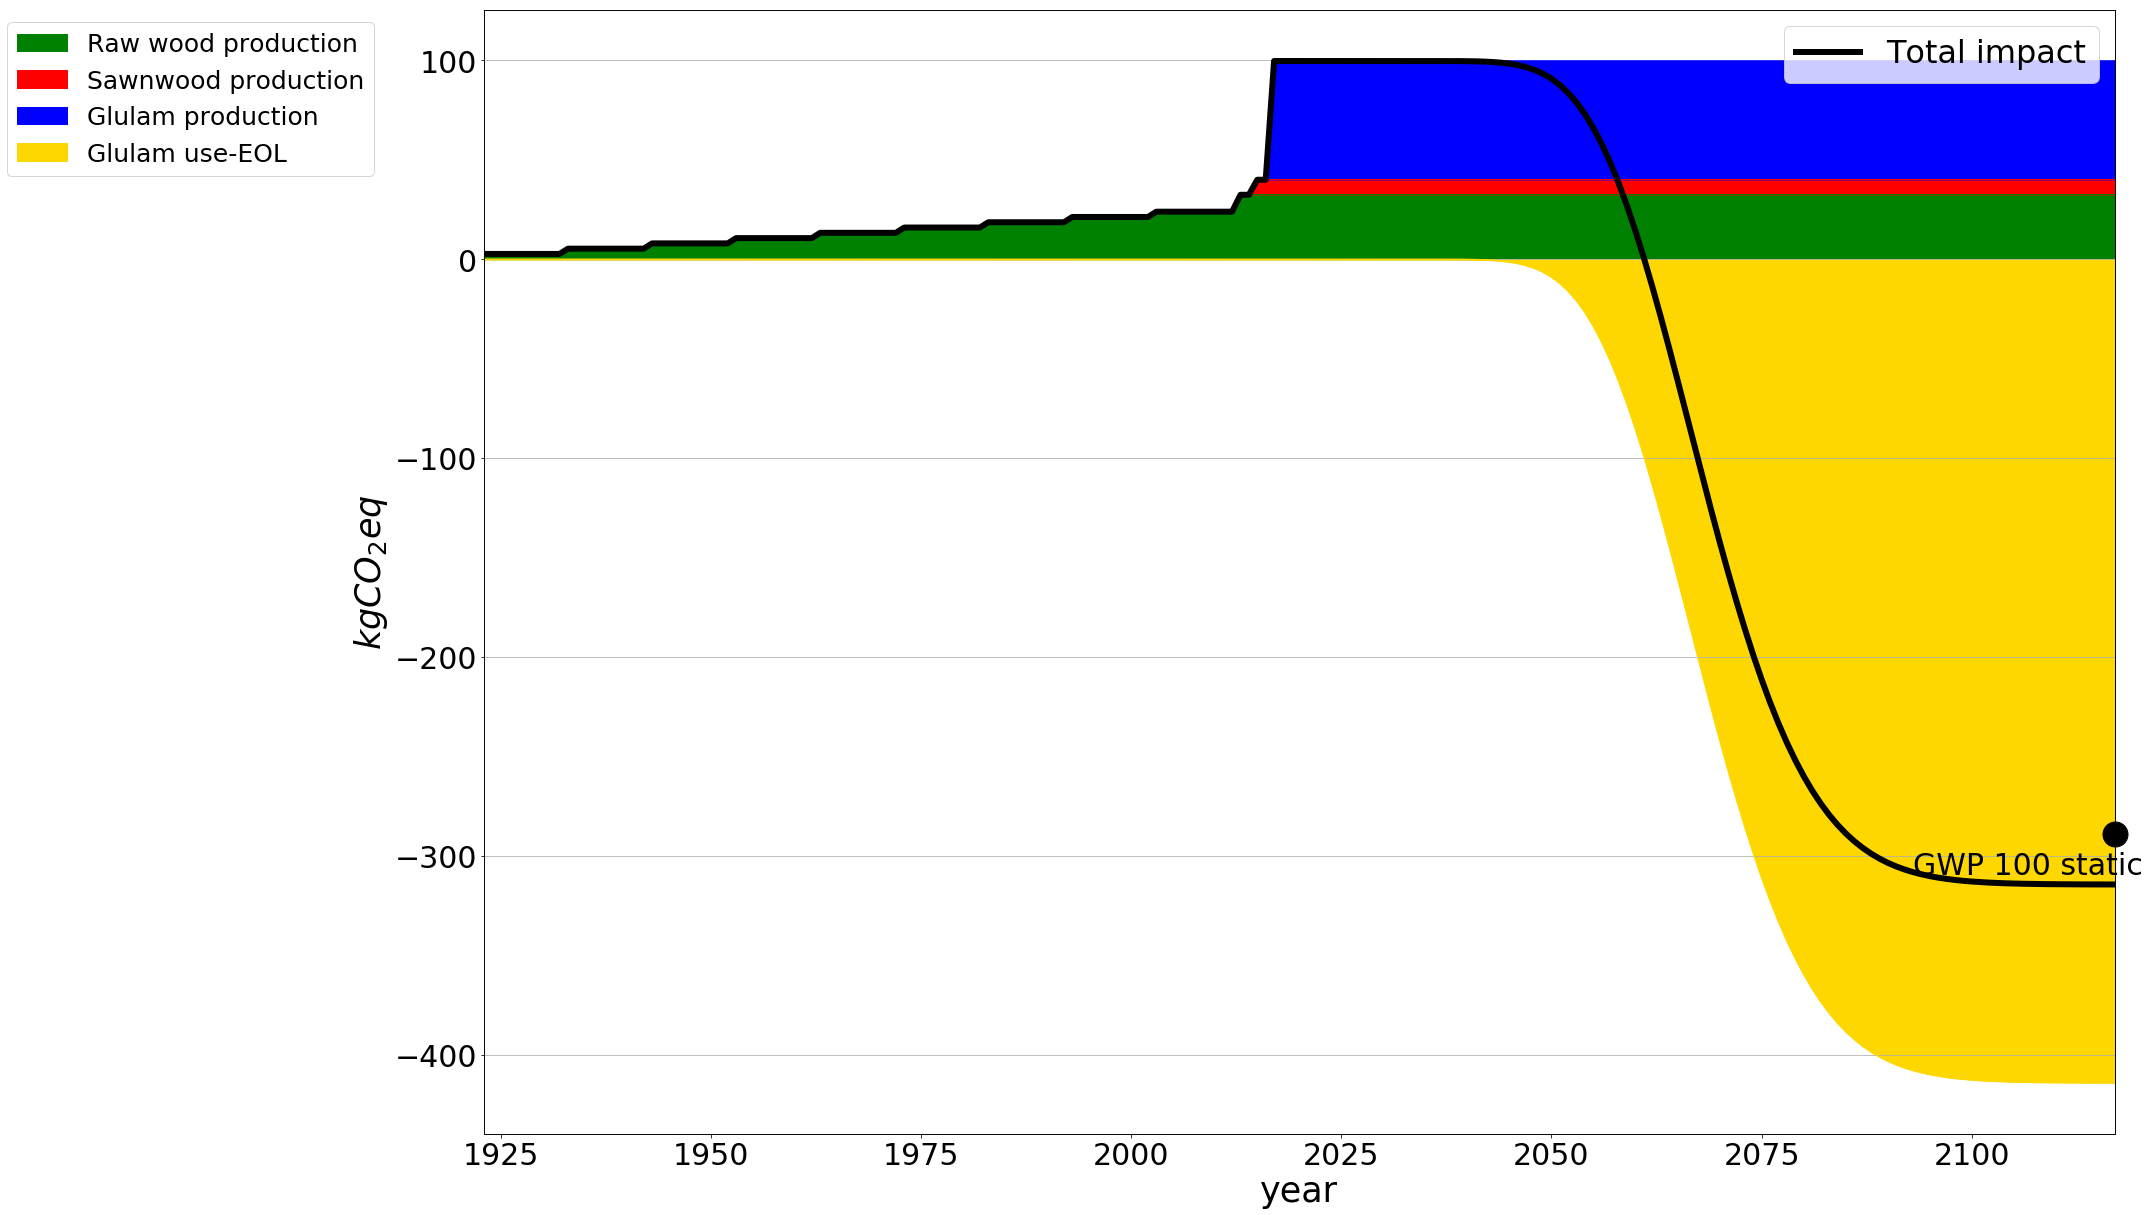

In [10]:
#plot 100 years
size_font=30


#to make everything bold see https://stackoverflow.com/a/43111170/4929813
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

fig, ax = plt.subplots(figsize=(11.69*2.5,8.27*2.5))#(33,18))
ax2 = ax.twiny()

#set colormap with palettable
# ax.set_color_cycle(palettable.tableau.Tableau_20.mpl_colors)

#plot
# df_st_CF.plot(kind='bar',stacked=True,legend=False,width=1.1,fontsize=size_font,ax=ax)#,colormap='Paired')
df_st_CF.loc[:2017+100].plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.iloc[:len(df_st_CF.loc[:2017+100])].plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax.grid(True,axis='y')

#adjsut legend
#correct
ax.legend(bbox_to_anchor=(-0.3, 1),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
ax2.legend(["Total impact"],fontsize=size_font+2,loc='upper right')


#x-ylabel
ax.set_ylabel('$kg CO_2eq$',fontsize=size_font+5)
ax.set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


#####ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={100:('IPCC 2007', 'climate change', 'GWP 100a'),

         }
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
line = ax2.lines[0] 
zero=line.get_xdata()[0]
xcoords = [zero+100]
    
#this starting from 2017
for xc in xcoords:
        ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax2.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-60 if (xc-zero)==500 else xc+70, res[xc-zero]-20 ), 
                 size=size_font
                )




# # need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
# # #for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.eps', format='eps',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.svg', format='svg',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.png', format='png',dpi=500,bbox_inches='tight')

plt.show()


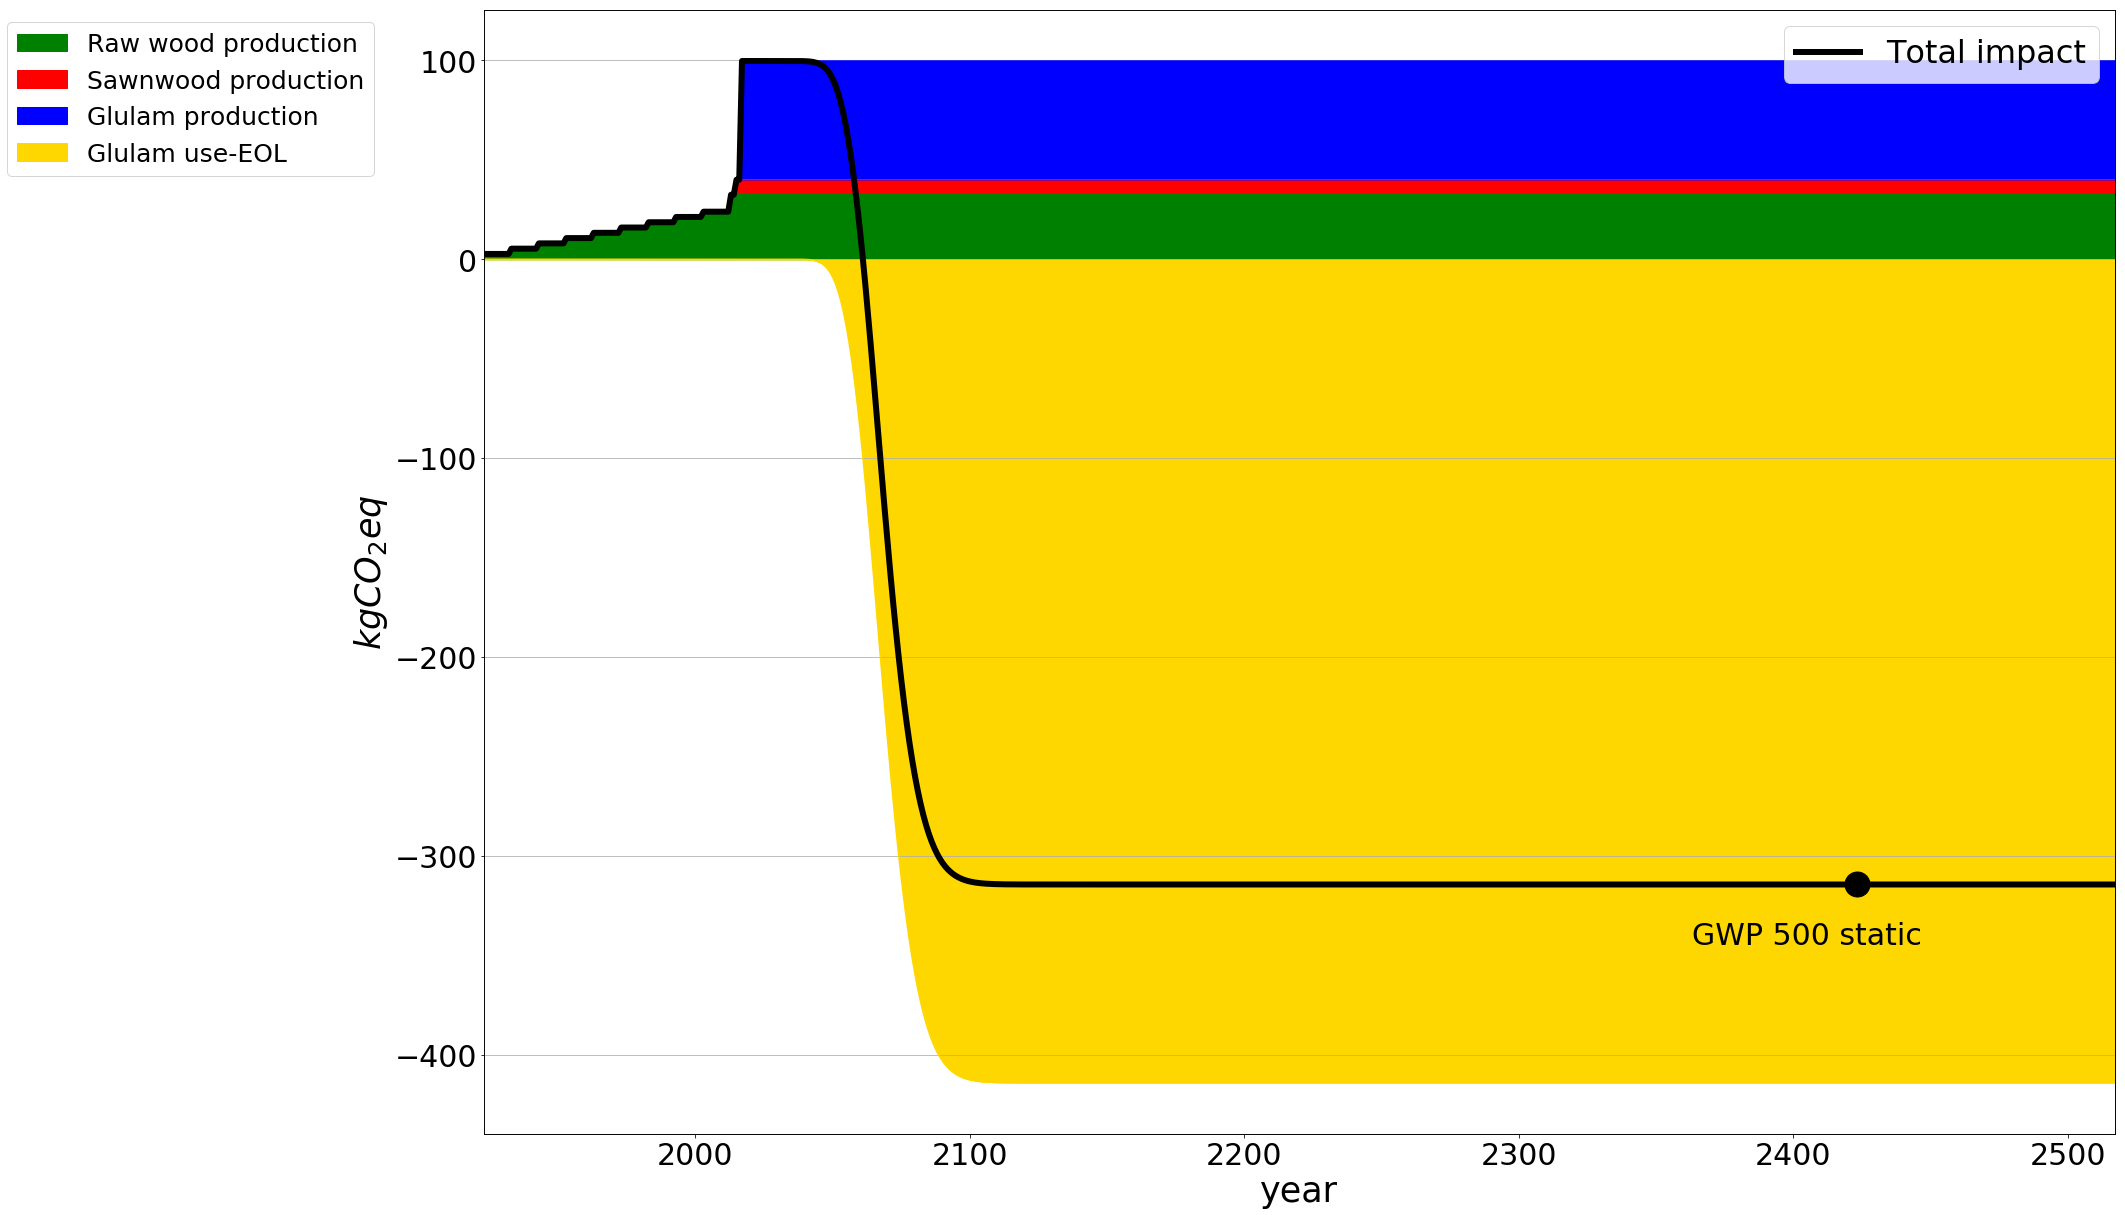

In [11]:
#plot 500 years
size_font=30


#to make everything bold see https://stackoverflow.com/a/43111170/4929813
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

fig, ax = plt.subplots(figsize=(11.69*2.5,8.27*2.5))#(33,18))
ax2 = ax.twiny()

#set colormap with palettable
# ax.set_color_cycle(palettable.tableau.Tableau_20.mpl_colors)

#plot
# df_st_CF.plot(kind='bar',stacked=True,legend=False,width=1.1,fontsize=size_font,ax=ax)#,colormap='Paired')
df_st_CF.plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax.grid(True,axis='y')

#adjsut legend
#correct
ax.legend(bbox_to_anchor=(-0.3, 1),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
ax2.legend(["Total impact"],fontsize=size_font+2,loc='upper right')


#x-ylabel
ax.set_ylabel('$kg CO_2eq$',fontsize=size_font+5)
ax.set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


#####ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={500:('IPCC 2007', 'climate change', 'GWP 500a')
         }
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
line = ax2.lines[0] 
zero=line.get_xdata()[0]
xcoords = [zero+500]
    
#this starting from 2017
for xc in xcoords:
    ax2.plot([xc], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
    ax2.annotate('GWP {} static'.format(xc-zero),
             xy=(xc-60 if (xc-zero)==500 else xc-10, res[xc-zero]-30 ), 
             size=size_font)

#                  xy=(xc-60 if (xc-zero)==500 else xc+70, res[xc-zero]-20 ), 



# # need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
# # #for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.eps', format='eps',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.svg', format='svg',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.png', format='png',dpi=500,bbox_inches='tight')

plt.show()


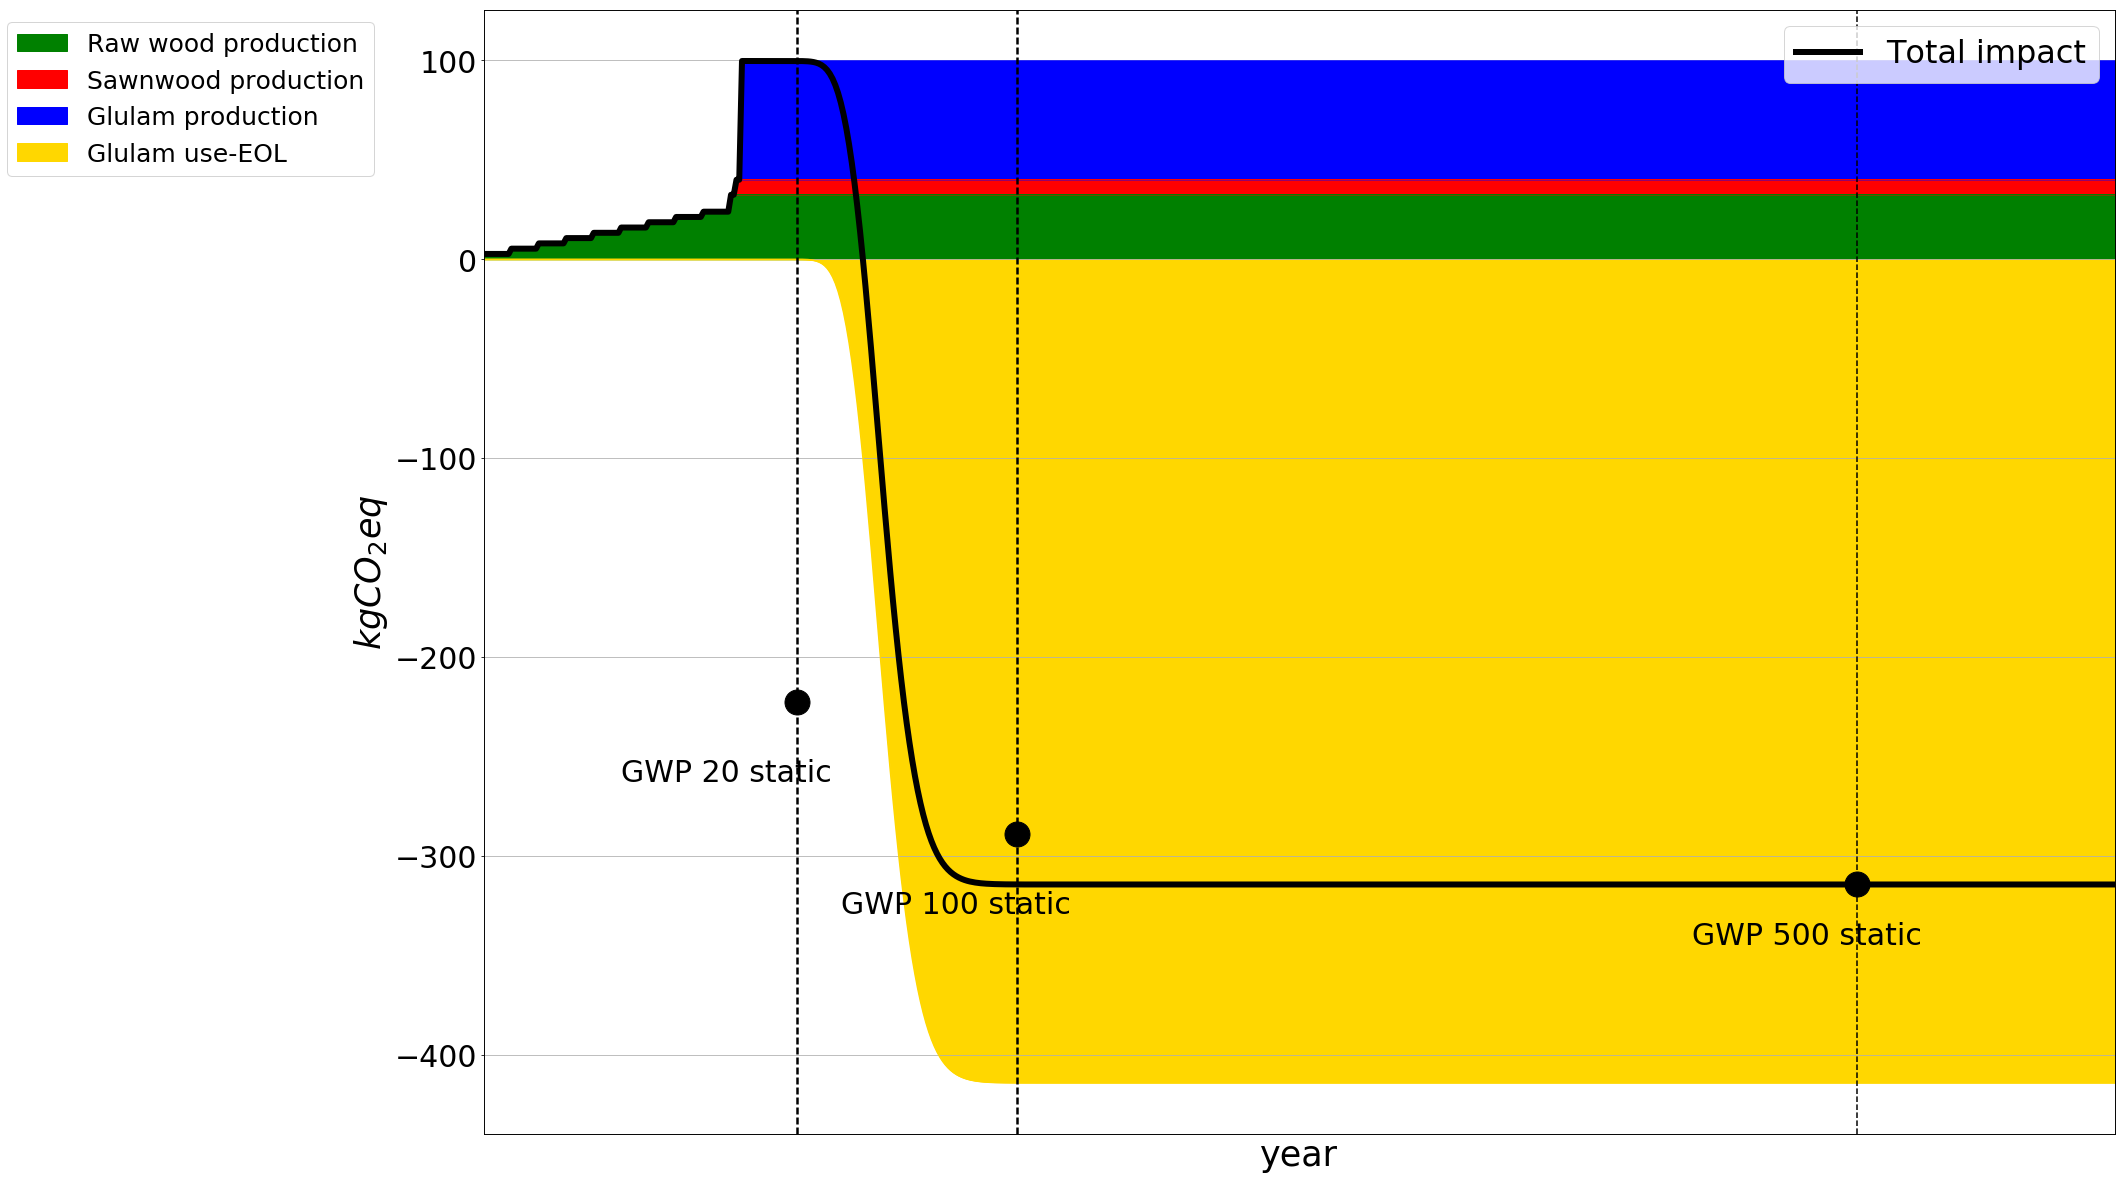

In [12]:
#plot 500 years
size_font=30


#to make everything bold see https://stackoverflow.com/a/43111170/4929813
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

fig, ax = plt.subplots(figsize=(11.69*2.5,8.27*2.5))#(33,18))
ax2 = ax.twiny()

#set colormap with palettable
# ax.set_color_cycle(palettable.tableau.Tableau_20.mpl_colors)

#plot
# df_st_CF.plot(kind='bar',stacked=True,legend=False,width=1.1,fontsize=size_font,ax=ax)#,colormap='Paired')
df_st_CF.plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#adjust xticks number of ticks
n = 50
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n], rotation=0)

#show horizontal grids
ax.grid(True,axis='y')

#adjsut legend
#correct
ax.legend(bbox_to_anchor=(-0.3, 1),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
ax2.legend(["Total impact"],fontsize=size_font+2,loc='upper right')


#x-ylabel
ax.set_ylabel('$kg CO_2eq$',fontsize=size_font+5)
ax.set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


#####ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a'),
          100:('IPCC 2007', 'climate change', 'GWP 100a'),
          500:('IPCC 2007', 'climate change', 'GWP 500a')}
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
line = ax2.lines[0] 
zero=line.get_xdata()[0]
xcoords = [zero+20,zero+100,zero+500]
    
#this starting from 2017
for xc in xcoords:
    if xc-zero==500: #move everything a bit more on the left
        ax2.axvline(x=xc,linewidth=1.5, color = 'k', linestyle='--') #lines
        ax2.plot([xc], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax2.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-60 if (xc-zero)==500 else xc-10, res[xc-zero]-30 ), 
                 size=size_font)
    else:
        ax2.axvline(x=xc-zero+2017,linewidth=2.5, color = 'k', linestyle='--') #lines
        ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax2.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-60 if (xc-zero)==500 else xc+30, res[xc-zero]-40 ), 
                 size=size_font
                )




# # need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
# # #for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.eps', format='eps',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.svg', format='svg',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.png', format='png',dpi=500,bbox_inches='tight')

plt.show()


# dynamic LCI dynamic LCIA

In [13]:
fu={('tempo', 'glulam_FU'): 1}

dynlca = DynamicLCA(fu, ('RadiativeForcing','worst case'),now=np.datetime64('2017-01-01'),cutoff=0.00000001,loop_cutoff=10,group=True)
time_dyn=dynlca.calculate()

In [14]:
#calculate total radiative forcing
yr,resul=time_dyn.characterize_dynamic('RadiativeForcing',cumulative=False)

#calulate overall results with levasseur approach
# sum(resul[:500])/sum(co2_rf_td.values[:500]) 
sum(resul[:lenght])/sum(co2_rf_td.values[:lenght]) #correct



-120.78867474922956

In [15]:
#create dict with results by process

dyn_CF={}
for pr in time_dyn.processes():
    yr_pr_dyn,res_pr_dyn=time_dyn.timeline_for_activity(pr).characterize_dynamic('RadiativeForcing',cumulative=True)
    dyn_CF[get_activity(pr)['name']]=[yr_pr_dyn,res_pr_dyn]

In [16]:
# # dump pickle
# with open('test.pickle', 'wb') as handle:
#     pickle.dump(test, handle)

# import pickle
# with open('test.pickle', 'rb') as handle:
#     dyn_CF = pickle.load(handle)

In [17]:
#convert dict with results to dataframe
df_dyn_CF=pd.DataFrame({k:pd.Series(v[1], index=v[0]) for (k,v) in dyn_CF.items() if len(v[0])>0})
df_dyn_CF.index=df_dyn_CF.index.map(int)#to have int in x axis


In [18]:
#clauclate co2 integral and divide everything by it to calculate gwp

# df_dyn_CF['co2']=sum(co2_rf_td.values[:501]) #old, is wrong

# df_dyn_CF=df_dyn_CF[:501]

df_dyn_CF=df_dyn_CF[:lenght] #correct

# df_dyn_CF['co2']=co2_rf_td.values[:501].cumsum() #check if this or one before df_dyn_CF=df_dyn_CF[:501]
df_dyn_CF['co2']=co2_rf_td.values[:lenght].cumsum() #check if this or one before df_dyn_CF=df_dyn_CF[:501] #correcrt

cum_co2=df_dyn_CF['co2'] #needed below to subtract biogenic carbon

df_dyn_CF=df_dyn_CF.iloc[:,:-1].div(df_dyn_CF.co2, axis=0) #calculate gwp and delete col with gwp of co2
#calculate tot
tot=df_dyn_CF.sum(axis=1)#.sum()


In [19]:
#calculate tot
tot=df_dyn_CF.sum(axis=1)#.sum()

In [20]:
#calculate total impact without biogenic carbon
#calc biogenic impact
yr_bio_dyn,res_bio_dyn=timeline.timeline_for_flow(('static_forest','C_biogenic')).characterize_dynamic('RadiativeForcing',cumulative=True)
df_bio=pd.Series(res_bio_dyn, index=yr_bio_dyn)
df_bio.index=df_bio.index.map(int)#to have int in x axis

#calculate gpw biogenic
# df_bio=df_bio.iloc[:501]
df_bio=df_bio.iloc[:lenght]#correct
impact_bio=df_bio.div(cum_co2)
# subtract to tot
tot_no_bio=tot-impact_bio

In [21]:
#check year when impacts are zero
delay=292
# tot[a:a+1]
tot.loc[2017+delay-1:2017+delay]


2308    0.707460
2309   -0.200796
dtype: float64

In [22]:
#cumulative impact over 500 years
df_dyn_CF[-1:].sum().sum()

-120.78867474922939

In [23]:
#rename columns
df_dyn_CF.rename(columns=names_cols ,inplace=True)

#merge duplicate columns
df_dyn_CF=df_dyn_CF.T.groupby(df_dyn_CF.T.index).sum().T

#reorder cols to better graph
dyn_cols_order=[]
for index, row in df_dyn_CF.iterrows():
    for x,y in row.iteritems():
        if pd.notnull(y) and x not in dyn_cols_order:
            dyn_cols_order.append(x)

df_dyn_CF = df_dyn_CF[dyn_cols_order]
            

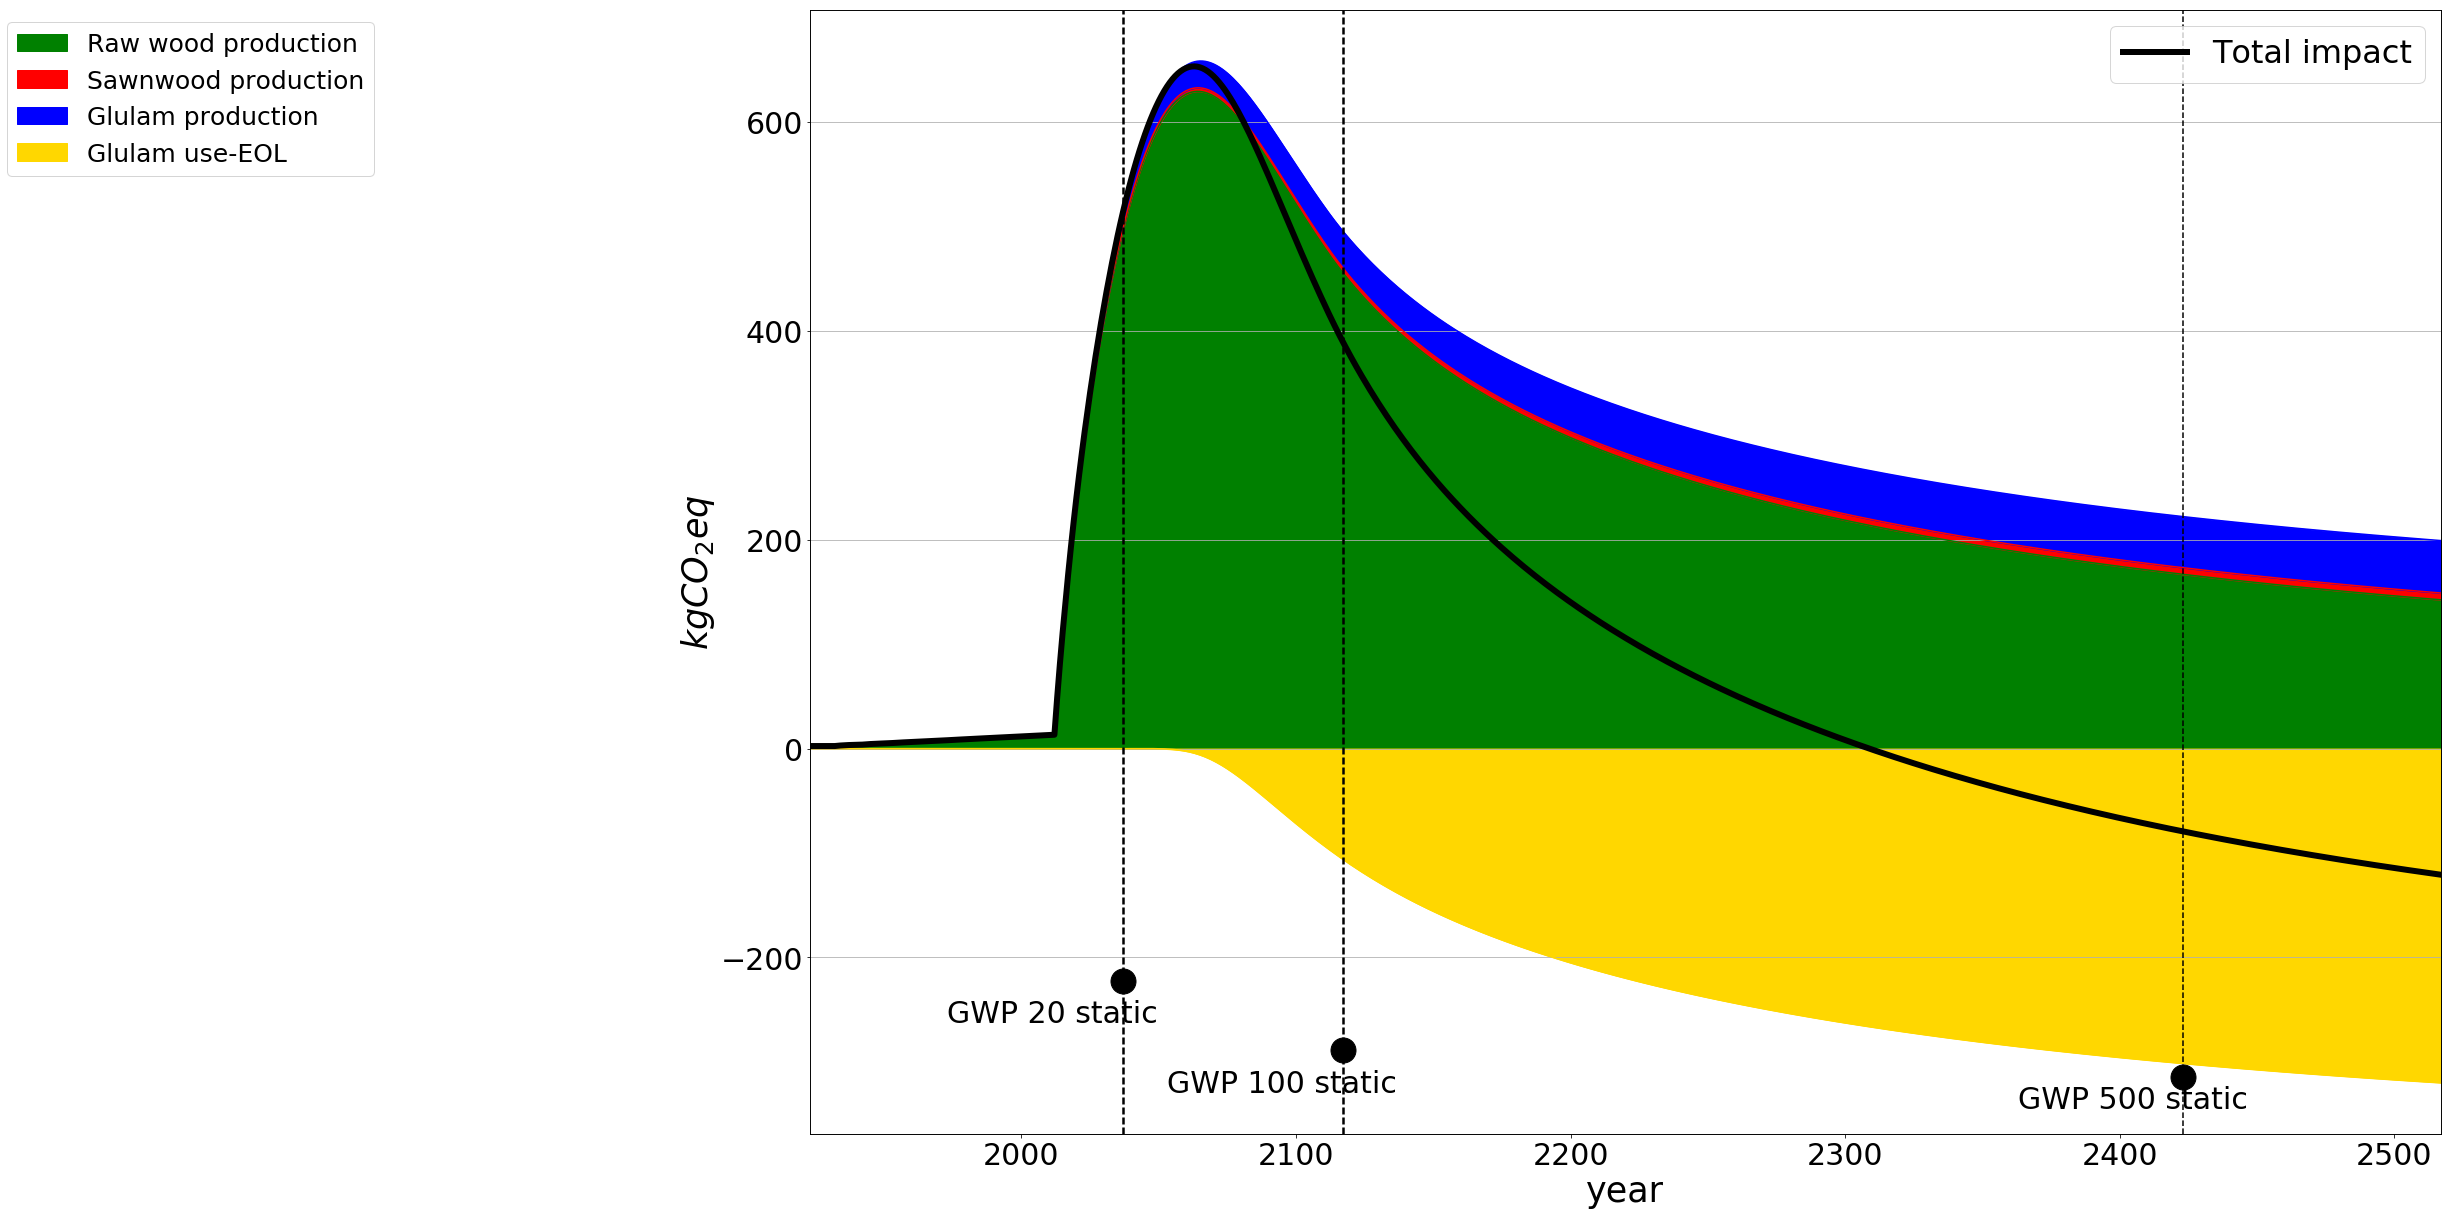

In [24]:
#plot dyn

size_font=30


#to make everything bold see https://stackoverflow.com/a/43111170/4929813
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

fig, ax = plt.subplots(figsize=(11.69*2.5,8.27*2.5))#(33,18))
ax2 = ax.twiny()

#to set the number of xticks
ax.locator_params(axis='x',nbins=10)

#plot
# df_dyn_CF.plot(kind='bar',stacked=True,legend=False,width=1.1,fontsize=size_font,ax=ax)#,colormap='Paired')
df_dyn_CF.plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax,color=[colors[i] for i in df_dyn_CF.columns])#,colormap='Paired') #this is correct
tot.plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

# # adjust xticks number of ticks (not working with plot.area)
# n = 50
# ticks = ax.xaxis.get_ticklocs()
# ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
# print(ticklabels)
# ax.xaxis.set_ticks(ticks[::n])
# ax.xaxis.set_ticklabels(ticklabels[::n], rotation=0)

#show horizontal grids
ax.grid(True,axis='y')

#adjsut legend
ax.legend(bbox_to_anchor=(-0.5, 1),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
ax2.legend(["Total impact"],fontsize=size_font+2,loc='upper right')


#x-ylabel
ax.set_ylabel('$kg CO_2eq$',fontsize=size_font+5)
ax.set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


######ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a'),
          100:('IPCC 2007', 'climate change', 'GWP 100a'),
          500:('IPCC 2007', 'climate change', 'GWP 500a')}
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
line = ax2.lines[0] 
zero=line.get_xdata()[0]
xcoords = [zero+20,zero+100,zero+500]
    
#this starting from 2017
for xc in xcoords:
    if xc-zero==500: #move everything a bit more on the left
        ax2.axvline(x=xc,linewidth=1.5, color = 'k', linestyle='--') #lines
        ax2.plot([xc], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax2.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-60 if (xc-zero)==500 else xc-10, res[xc-zero]-30 ), 
                 size=size_font)
    else:
        ax2.axvline(x=xc-zero+2017,linewidth=2.5, color = 'k', linestyle='--') #lines
        ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax2.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-60 if (xc-zero)==500 else xc+30, res[xc-zero]-40 ), 
                 size=size_font
                )


# need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
#for the presentation
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/conferences/bart_dgclima_17/figures/glulam_results.eps', format='eps',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/conferences/bart_dgclima_17/figures/glulam_results.svg', format='svg',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/conferences/bart_dgclima_17/figures/glulam_results.png', format='png',dpi=400,bbox_inches='tight')

# need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
#for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.eps', format='eps',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.svg', format='svg',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.png', format='png',dpi=500,bbox_inches='tight')


plt.show()


In [25]:
# df_dyn_CF.index

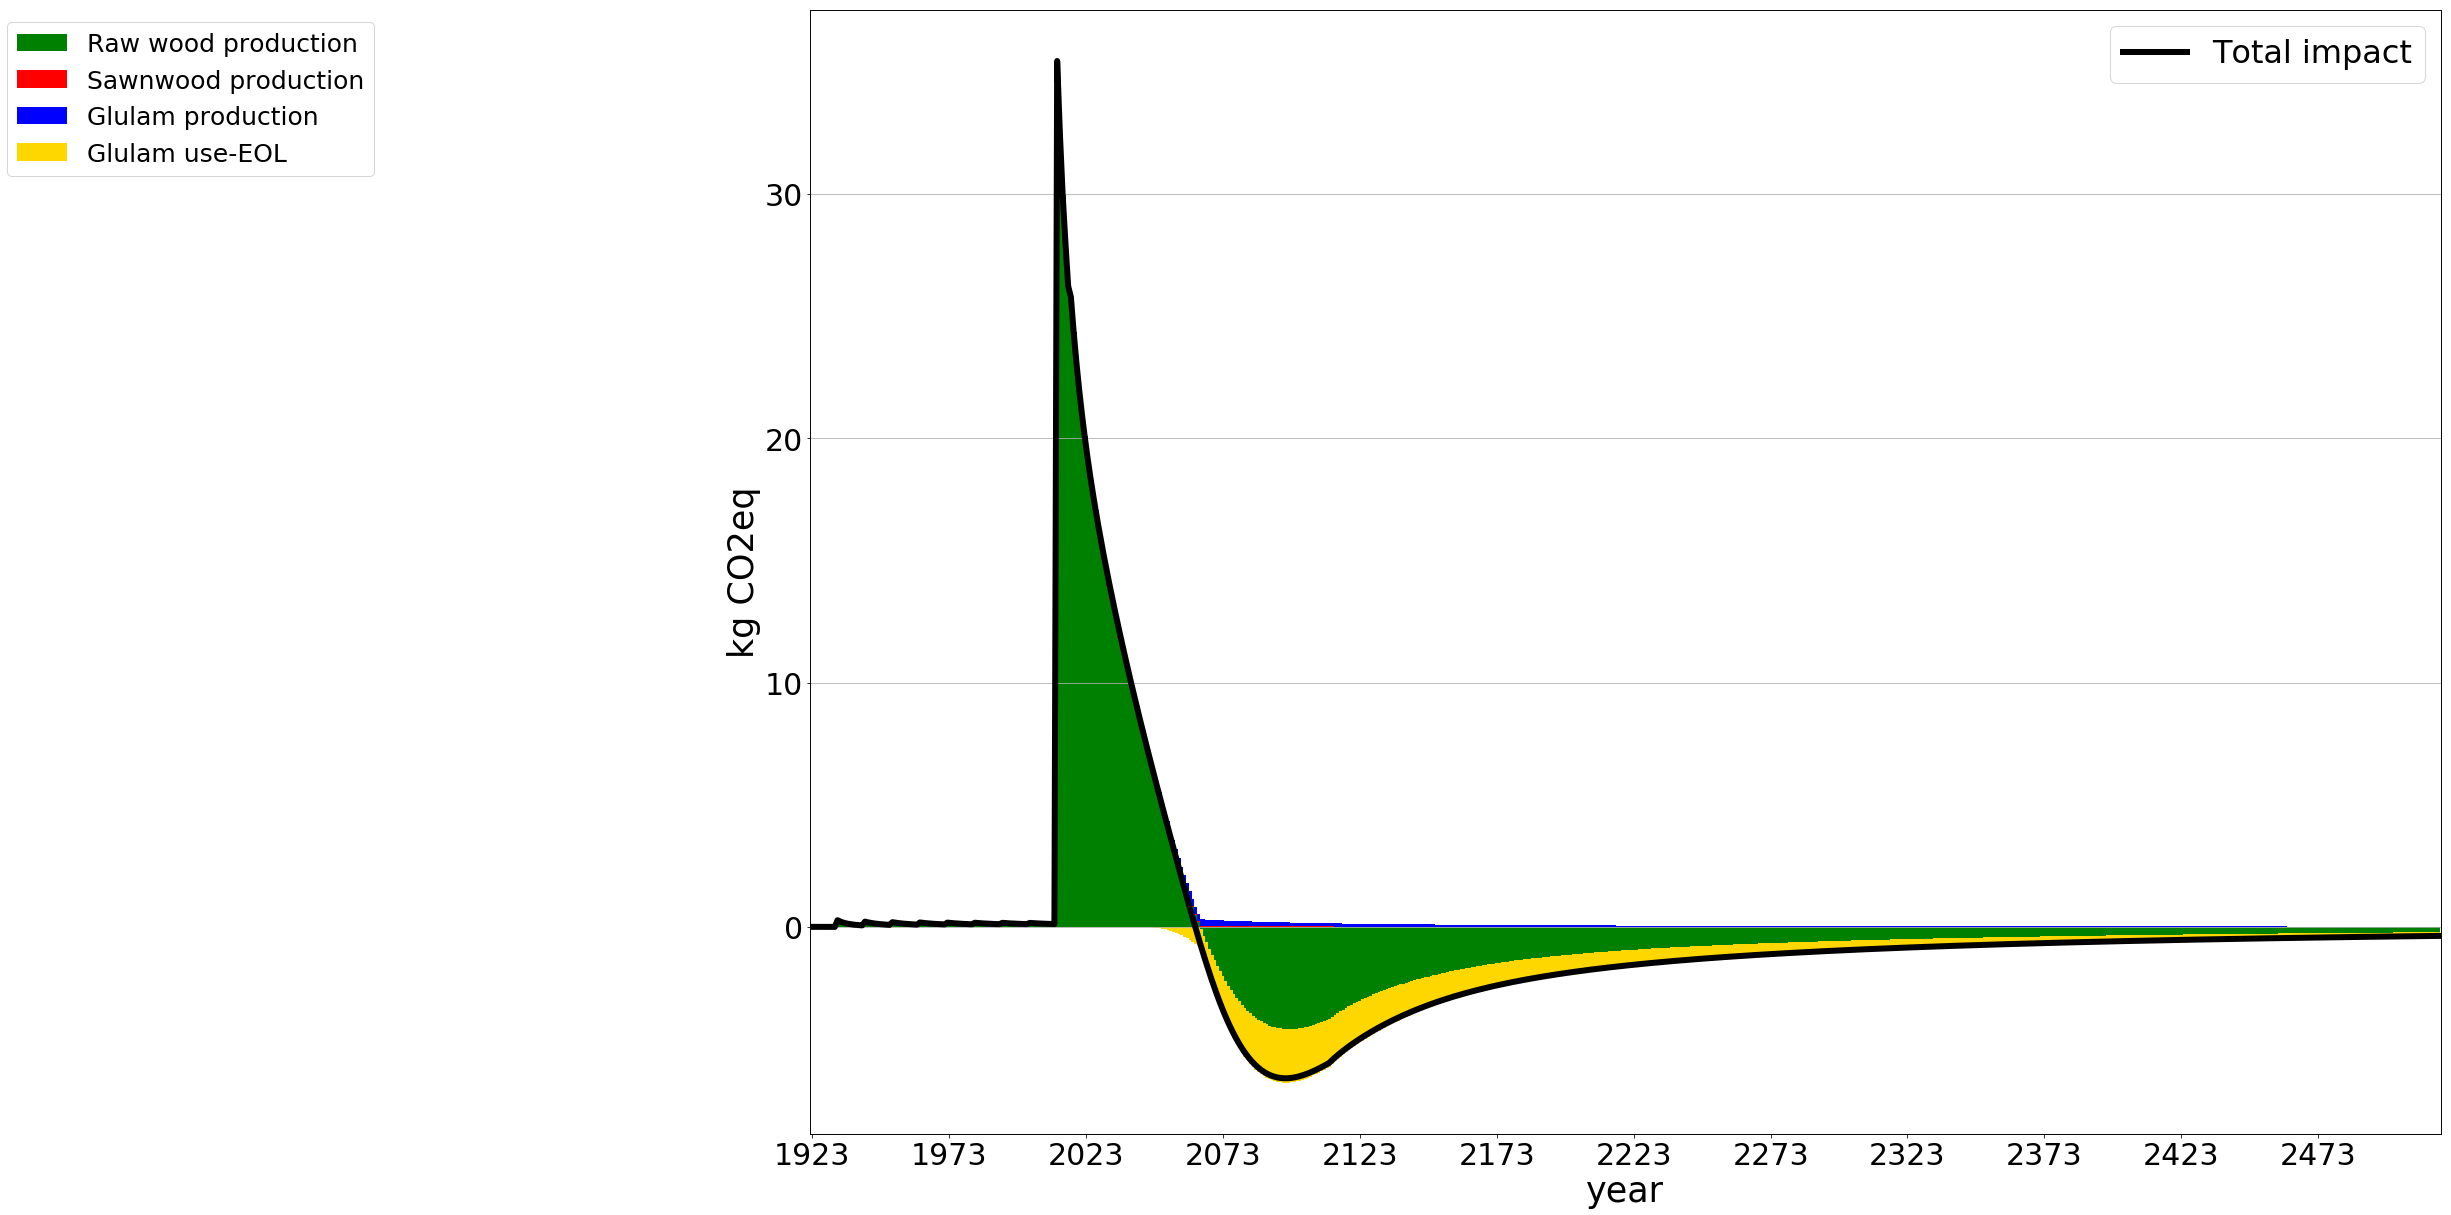

In [26]:
#test: plot non cumulative

df_non_cum=df_dyn_CF.diff(axis=0)
tot_non_cum=df_non_cum.sum(axis=1)#.sum()



size_font=30


#to make everything bold see https://stackoverflow.com/a/43111170/4929813
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

fig, ax = plt.subplots(figsize=(11.69*2.5,8.27*2.5))#(33,18))
ax2 = ax.twiny()

# df_non_cum.iloc[:5,:-1].plot(kind='bar',stacked=True,legend=False,width=1,fontsize=18,ax=ax)
# tot_non_cum[:5].plot(linestyle='-', linewidth=6,color='black',legend=True)

df_non_cum.plot(kind='bar',stacked=True,legend=False,width=1.1,fontsize=size_font,ax=ax,color=[colors[i] for i in df_non_cum.columns])#,colormap='Paired')
tot_non_cum.plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#adjust xticks number of ticks
n = 50
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n], rotation=0)

#show horizontal grids
ax.grid(True,axis='y')

#adjsut legend
#correct
ax.legend(bbox_to_anchor=(-0.5, 1),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
ax2.legend(["Total impact"],fontsize=size_font+2,loc='upper right')
#not correct
# ax.legend(ax.get_legend_handles_labels()[1]+['Total impact'],#add total impact to legend, does not work
# ax.legend(ncol=2,fontsize=16,loc='lower left', framealpha=0) framealpha=0 make transparent


#x-ylabel
ax.set_ylabel('kg CO2eq',fontsize=size_font+5)
ax.set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


plt.show()


In [27]:
# tot

## merge two graphs for paper


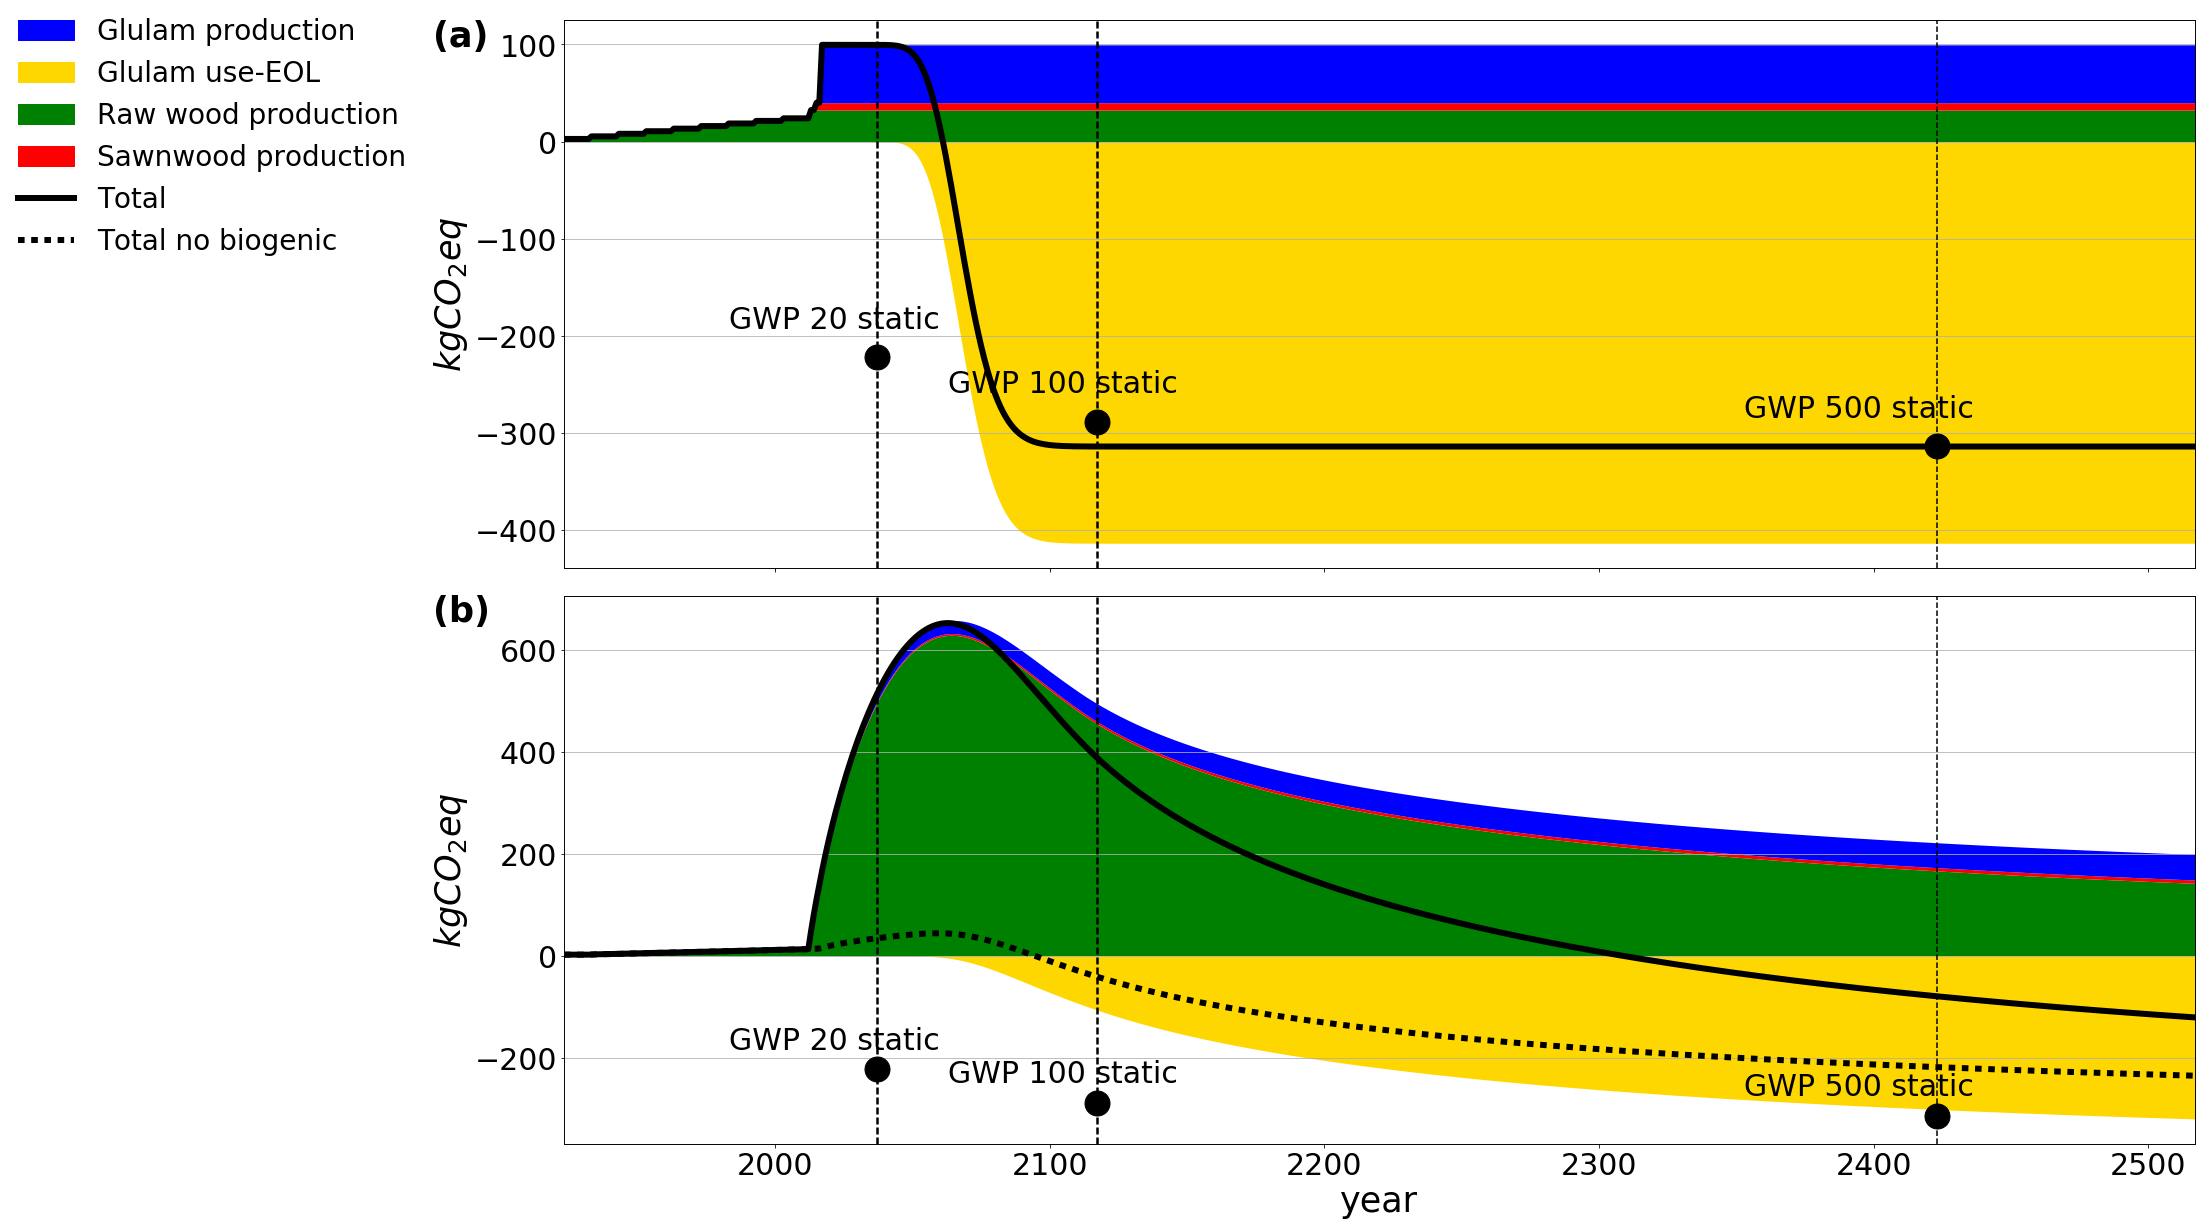

In [28]:
#plot for paper
size_font=30


# #to make everything bold see https://stackoverflow.com/a/43111170/4929813
plt.rcParams["font.weight"] = "medium"
plt.rcParams["axes.labelweight"] = "medium"


# #create dict with cols:colors
# columns = list(set(df_st_CF.columns.tolist() + df_dyn_CF.columns.tolist())) + ['Total']
# colors = dict(zip(columns,palettable.tableau.Tableau_20.mpl_colors[:4]+['black'])) #correct one

#make canvas
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(11.69*2.5,8.27*2.5))#(33,18)) #test all togehter
ax2 = ax[0].twiny()


#plot
df_st_CF.plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax[0], lw=0,color=[colors[i] for i in df_st_CF.columns])
tot_st.plot(linestyle='-', linewidth=6,color=colors['Total'] ,legend=False,fontsize=size_font)


# # adjust xticks number of ticks (not working with plot.area)
# n = 50
# ticks = ax[0].xaxis.get_ticklocs()
# ticklabels = [l.get_text() for l in ax[0].xaxis.get_ticklabels()]
# ax[0].xaxis.set_ticks(ticks[::n])
# ax[0].xaxis.set_ticklabels(ticklabels[::n], rotation=0)

#show horizontal grids
ax[0].grid(True,axis='y')

#x-ylabel
ax[0].set_ylabel('$kg CO_2eq$',fontsize=size_font+5)
ax[0].set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


###############SECOND GRAPH###########################

ax3 = ax[1].twiny()

#plot
df_dyn_CF.plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax[1],sharex=ax[0], lw=0,color=[colors[i] for i in df_dyn_CF.columns])
tot.plot(linestyle='-', linewidth=6,color=colors['Total'] ,legend=False,fontsize=size_font)
tot_no_bio.plot(linestyle=':', linewidth=6,color=colors['Total no biogenic'] ,legend=False,fontsize=size_font)

# # adjust xticks number of ticks (not working with plot.area)
# n = 50
# ticks = ax[1].xaxis.get_ticklocs()
# ticklabels = [l.get_text() for l in ax[1].xaxis.get_ticklabels()]
# ax[1].xaxis.set_ticks(ticks[::n])
# ax[1].xaxis.set_ticklabels(ticklabels[::n], rotation=0)

#show horizontal grids
ax[1].grid(True,axis='y')

# #adjsut legend
# ax[1].legend(bbox_to_anchor=(-0.45, 2.2),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
# ax3.legend(["Total impact"],fontsize=size_font+2,loc='upper right')

# labels=columns
# handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels]


labels=columns 
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels[:4]] #[:4] to not take the two totals

line_tots=[plt.Line2D((0,2),(0,0), color='k', linestyle='-',linewidth=6),#line for total
          plt.Line2D((0,2),(0,0), color='k', linestyle=':',linewidth=6)]#line for total wihotu bio

handles+=line_tots

ax[1].legend(handles=handles, labels=labels,bbox_to_anchor=(-0.35, 2.1),fontsize=size_font-2, loc='upper left', ncol=1,frameon=False) #put it outside the graph


#x-ylabel
ax[1].set_ylabel('$kg CO_2eq$',fontsize=size_font+5)
ax[1].set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

#to set the number of xticks (untill part above not fixed)
ax[1].locator_params(axis='x',nbins=10)

# ######ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a'),
          100:('IPCC 2007', 'climate change', 'GWP 100a'),
          500:('IPCC 2007', 'climate change', 'GWP 500a')}
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
line = ax3.lines[0] 
zero=line.get_xdata()[0]
xcoords = [zero+20,zero+100,zero+500]
    
# for first graph
for xc in xcoords:
    if xc-zero==500: #move everything a bit more on the left
        ax2.axvline(x=xc,linewidth=1.5, color = 'k', linestyle='--') #lines
        ax2.plot([xc], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax2.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-70 if (xc-zero)==500 else xc-10, res[xc-zero]+30 ), 
                 size=size_font)
    else:
        ax2.axvline(x=xc-zero+2017,linewidth=2.5, color = 'k', linestyle='--') #lines
        ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax2.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-70 if (xc-zero)==500 else xc+40, res[xc-zero]+30 ), 
                 size=size_font
                )


# for second graph
for xc in xcoords:
    if xc-zero==500: #move everything a bit more on the left
        ax3.axvline(x=xc,linewidth=1.5, color = 'k', linestyle='--') #lines
        ax3.plot([xc], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax3.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-70 if (xc-zero)==500 else xc-10, res[xc-zero]+40 ), 
                 size=size_font)
    else:
        ax3.axvline(x=xc-zero+2017,linewidth=2.5, color = 'k', linestyle='--') #lines
        ax3.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax3.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-70 if (xc-zero)==500 else xc+40, res[xc-zero]+40 ), 
                 size=size_font
                )
        
        
# enumerate suplots
ax2.annotate('(a)', xy=(-.08, 1), xycoords='axes fraction', fontsize=size_font+5,  textcoords='offset points',   ha='left', va='top',fontweight='semibold')
ax3.annotate('(b)', xy=(-.08, 1), xycoords='axes fraction', fontsize=size_font+5,  textcoords='offset points',   ha='left', va='top',fontweight='semibold')

#reduce space between graphs
plt.subplots_adjust(wspace=0, hspace=0.05)


# # need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
# # #for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.eps', format='eps',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.svg', format='svg',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.png', format='png',dpi=500,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.pdf', format='pdf',dpi=300,bbox_inches='tight')



plt.show()

## merge four graphs for paper


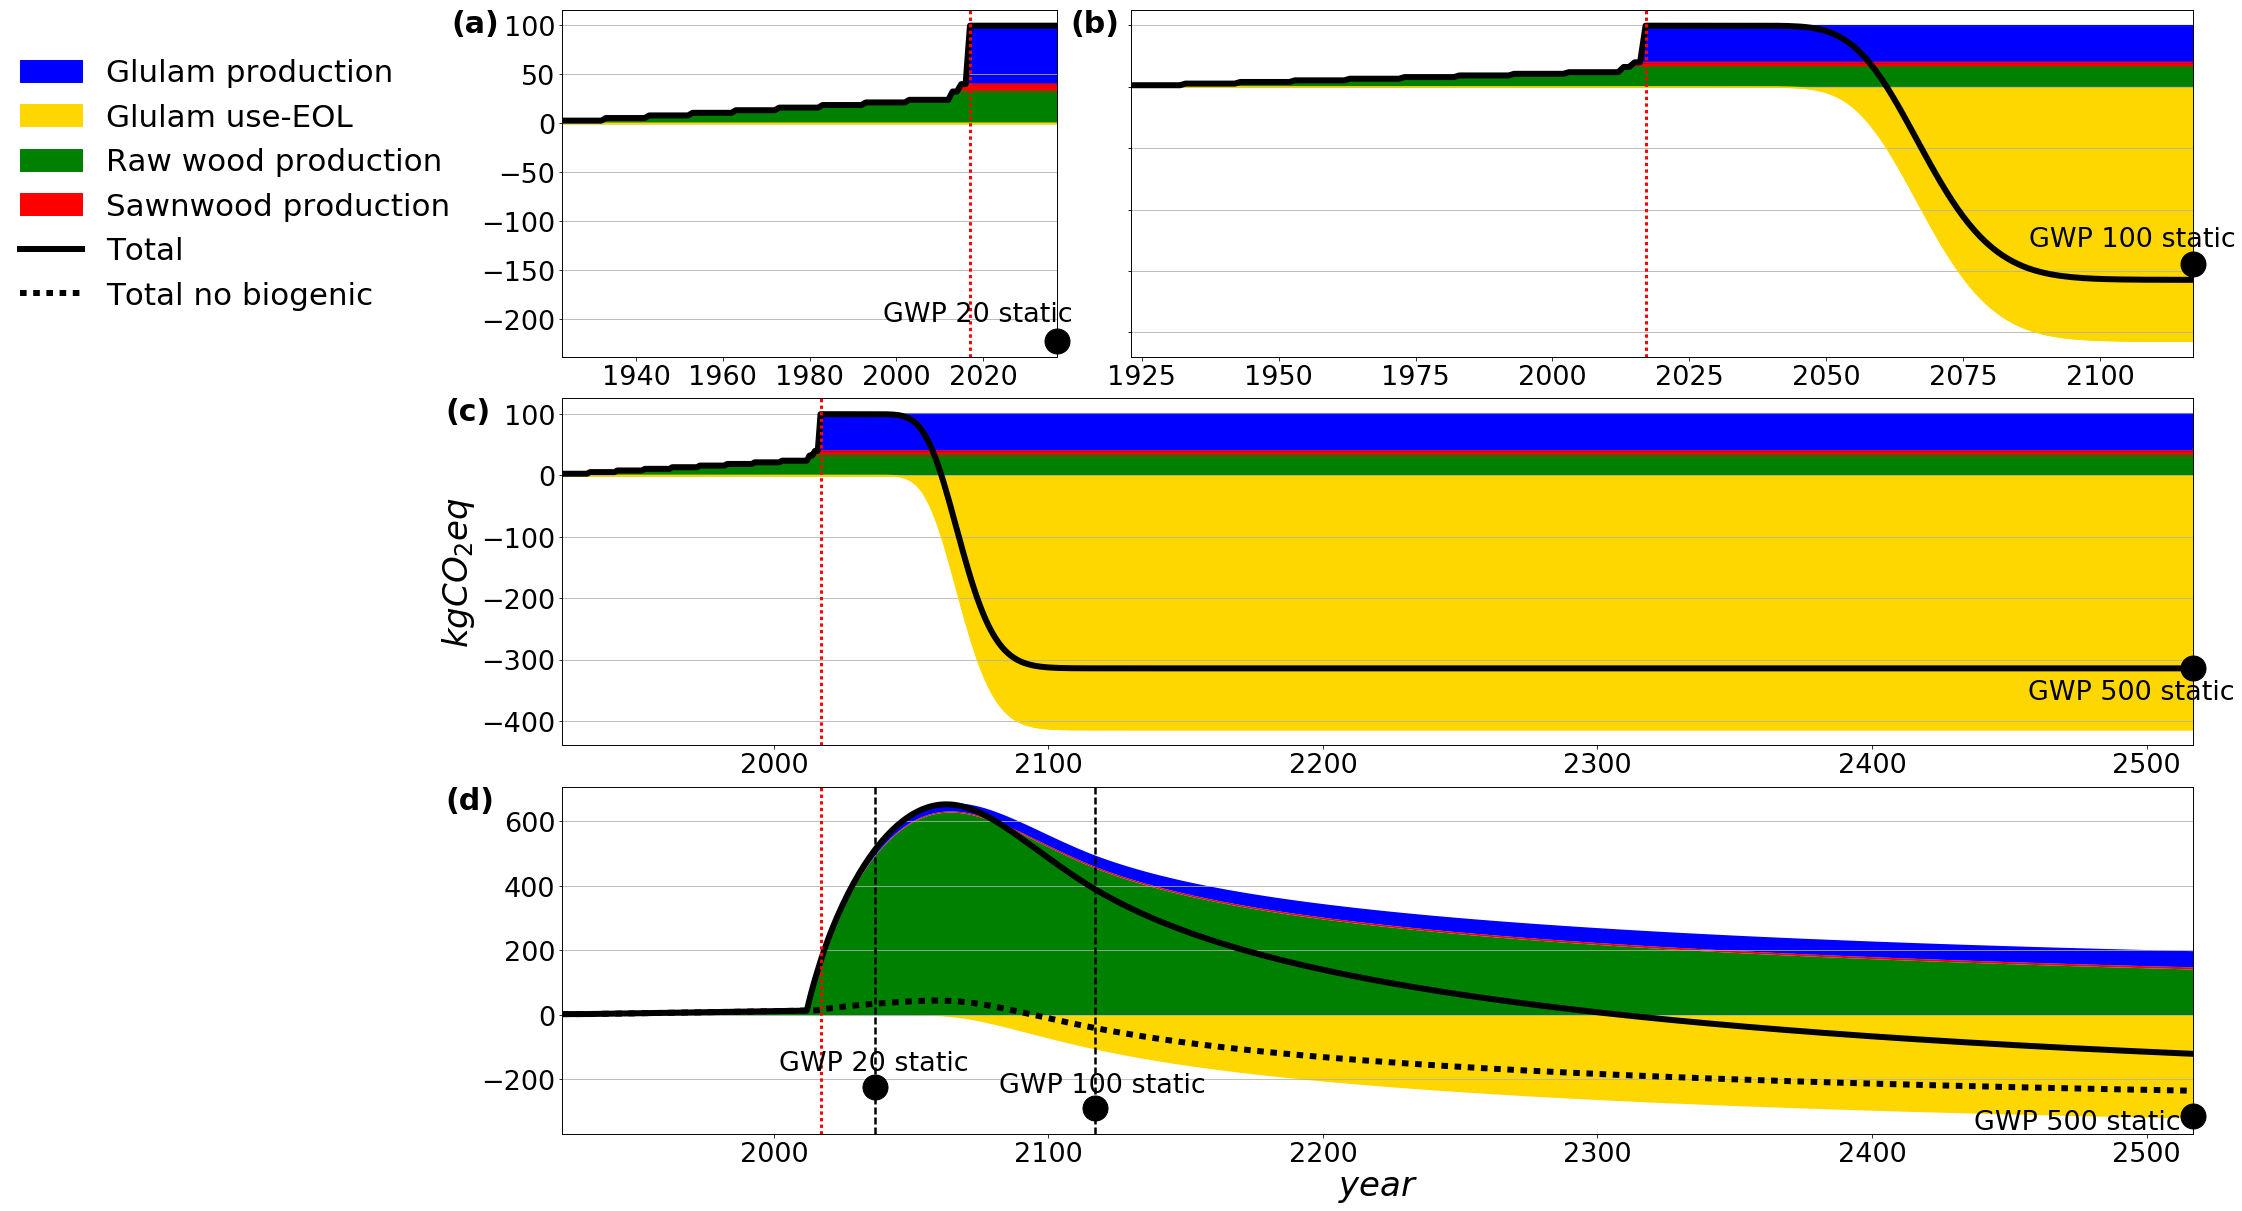

In [29]:
#plot for paper
size_font=27


# #to make everything bold see https://stackoverflow.com/a/43111170/4929813
plt.rcParams["font.weight"] = "medium"
plt.rcParams["axes.labelweight"] = "medium"

#make canvas

fig = plt.figure(figsize=(11.69*2.5,8.27*2.5)) #a4
# fig = plt.figure(figsize=(11.69*2,8.27*2.5)) #narrower

ax = plt.subplot(2, 2, 1)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax3 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
ax5 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
ax7 = plt.subplot2grid((3, 3), (2, 0), colspan=3)

###############GRAPH 20############

ax2 = ax1.twiny()

#plot
df_st_CF.loc[:2017+20].plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax1,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.iloc[:len(df_st_CF.loc[:2017+20])].plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax1.grid(True,axis='y')

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

#to set the number of xticks (untill part above not fixed)
ax2.locator_params(axis='x',nbins=10)


#ADD STATIC RESULTS

FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a')
         }
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
zero=2017
xcoords = [zero+20]
    
#this starting from 2017
for xc in xcoords:
    ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
    ax2.annotate('GWP {} static'.format(xc-zero),
             xy=(xc-40, res[xc-zero]+20), 

             size=size_font
            )
    
#add t0
ax2.axvline(2017,linewidth=3, color = 'r', linestyle=':') #lines

#####GRPH 100###########

ax4 = ax3.twiny()

#plot
df_st_CF.loc[:2017+100].plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax3,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.iloc[:len(df_st_CF.loc[:2017+100])].plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax3.grid(True,axis='y')

#remove extra ticks
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)


#####ADD STATIC RESULTS

FU={('tempo', 'glulam_FU'): 1}
all_meth={100:('IPCC 2007', 'climate change', 'GWP 100a'),

         }
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
zero=2017
xcoords = [zero+100]
    
#this starting from 2017
for xc in xcoords:
        ax4.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax4.annotate('GWP {} static'.format(xc-zero),
#                  xy=(xc+60, res[xc-zero]+30 ), 
                 xy=(xc-30, res[xc-zero]+30 ), 

                 size=size_font
                )

#add t0
ax4.axvline(2017,linewidth=3, color = 'r', linestyle=':') #lines

#####GRAPH 500#########

ax6 = ax5.twiny()

#plot
df_st_CF.plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax5,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax5.grid(True,axis='y')

#x-ylabel
ax5.set_ylabel('$kg CO_2eq$',fontsize=size_font+7)

#remove extra ticks
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)


#####ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={500:('IPCC 2007', 'climate change', 'GWP 500a')
         }
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
zero=2017
xcoords = [zero+500]
    
#this starting from 2017
for xc in xcoords:
    ax6.plot([xc], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
    ax6.annotate('GWP {} static'.format(xc-zero),
             xy=(xc-60, res[xc-zero]-50 ), 
             size=size_font)

#add t0
ax6.axvline(2017,linewidth=3, color = 'r', linestyle=':') #lines
        
# ###############GRAPH dynamic###########################

ax8 = ax7.twiny()

#plot
df_dyn_CF.plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax7,lw=0,color=[colors[i] for i in df_dyn_CF.columns])#,sharex=ax[0], lw=0,color=[colors[i] for i in df_dyn_CF.columns])
tot.plot(linestyle='-', linewidth=6,color=colors['Total'] ,legend=False,fontsize=size_font)
tot_no_bio.plot(linestyle=':', linewidth=6,color=colors['Total no biogenic'] ,legend=False,fontsize=size_font)


#show horizontal grids
ax7.grid(True,axis='y')

labels=columns 
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels[:4]] #[:4] to not take the two totals

line_tots=[plt.Line2D((0,2),(0,0), color='k', linestyle='-',linewidth=6),#line for total
          plt.Line2D((0,2),(0,0), color='k', linestyle=':',linewidth=6)]#line for total wihotu bio

handles+=line_tots

ax8.legend(handles=handles, labels=labels,bbox_to_anchor=(-0.35, 3.18),fontsize=size_font+4, loc='upper left', ncol=1,frameon=False) #put it outside the graph


#x-ylabel
ax7.set_xlabel('$year$',fontsize=size_font+7)

#remove extra ticks
ax8.get_xaxis().set_visible(False)
ax8.get_yaxis().set_visible(False)

#to set the number of xticks (untill part above not fixed)
ax8.locator_params(axis='x',nbins=10)

######ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a'),
          100:('IPCC 2007', 'climate change', 'GWP 100a'),
          500:('IPCC 2007', 'climate change', 'GWP 500a')}
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
zero=2017
xcoords = [zero+20,zero+100,zero+500]


#stati results
for xc in xcoords:
    if xc-zero==500: #move everything a bit more on the left
        ax8.plot([xc], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax8.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-80 , res[xc-zero]-40 ), 
                 size=size_font)
    else:
        ax8.axvline(x=xc,linewidth=2.5, color = 'k', linestyle='--') #lines
        ax8.plot([xc], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax8.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-35, res[xc-zero]+50 ), 

                 size=size_font
                )
#add t0
ax8.axvline(2017,linewidth=3, color = 'r', linestyle=':') #lines
        
# enumerate suplots
ax1.annotate('(a)', xy=(-.075*3, 1), xycoords='axes fraction', fontsize=size_font+3,  textcoords='offset points',   ha='left', va='top',fontweight='semibold')
ax3.annotate('(b)', xy=(-.057, 1), xycoords='axes fraction', fontsize=size_font+3,  textcoords='offset points',   ha='left', va='top',fontweight='semibold')
ax5.annotate('(c)', xy=(-.072, 1), xycoords='axes fraction', fontsize=size_font+3,  textcoords='offset points',   ha='left', va='top',fontweight='semibold')
ax7.annotate('(d)', xy=(-.072, 1), xycoords='axes fraction', fontsize=size_font+3,  textcoords='offset points',   ha='left', va='top',fontweight='semibold')

#reduce space between graphs
plt.subplots_adjust(wspace=0.15, hspace=0.12)


# need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
# # #for paper
plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.eps', format='eps',dpi=300,bbox_inches='tight')
plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.svg', format='svg',dpi=300,bbox_inches='tight')
plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.png', format='png',dpi=500,bbox_inches='tight')
plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.pdf', format='pdf',dpi=300,bbox_inches='tight')



plt.show()

# calculate differences in the results

In [77]:
#Relative Percentage Difference  (|Num1-Num2|/((Num1+Num2)/2)) x 100
FU={('tempo', 'glulam_FU'): 1}
all_meth=list(zip([20,100,500],[('IPCC 2007', 'climate change', 'GWP 20a'),('IPCC 2007', 'climate change', 'GWP 100a'),('IPCC 2007', 'climate change', 'GWP 500a')]))

res={}
for yr,m in all_meth:
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    st_res=l.score 
    print("OVER {} YEAR".format(yr))
    print("Relative Percentage Difference between the static and fully dynamic over {}: ".format(yr), abs(round((abs(st_res-tot.loc[2017+yr])/((st_res+tot.loc[2017+yr])/2))*100,2))) #reference st
    print("Relative Percentage Difference between the static and fully dynamic without biogenic over {}: ".format(yr), abs(round((abs(st_res-tot_no_bio.loc[2017+yr])/((st_res+tot_no_bio.loc[2017+yr])/2))*100,2))) #reference st
    print()
    print()

OVER 20 YEAR
Relative Percentage Difference between the static and fully dynamic over 20:  505.25
Relative Percentage Difference between the static and fully dynamic without biogenic over 20:  273.86


OVER 100 YEAR
Relative Percentage Difference between the static and fully dynamic over 100:  1346.47
Relative Percentage Difference between the static and fully dynamic without biogenic over 100:  150.66


OVER 500 YEAR
Relative Percentage Difference between the static and fully dynamic over 500:  88.93
Relative Percentage Difference between the static and fully dynamic without biogenic over 500:  28.78


